Joke Recommender System, continuation of assignment #4 of DSC 478

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as la
from numpy.random import randint
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline



#3. For this problem you will use a modified version of the item-based recommender algorithm from Ch. 14 of Machine Learning in Action and use it on joke ratings data based on Jester Online Joke Recommender System. 

The data set contains two files. The file "modified_jester_data.csv" contains the ratings on 100 jokes by 1000 users (each row is a user profile). The ratings have been normalized to be between 1 and 21 (a 20-point scale), with 1 being the lowest rating. A zero indicated a missing rating. The file "jokes.csv" contains the joke ids mapped to the actual text of the jokes.

Your tasks in this problem are the following (please also see comments for the function stubs in the provided module):



a. Load in the joke ratings data and the joke text data into appropriate data structures.


In [7]:
def load_jokes(file):
    jokes = np.genfromtxt(file, delimiter=',', dtype=str)
    jokes = np.array(jokes[:,1])
    return jokes

jes_df = np.genfromtxt("modified_jester_data.csv", delimiter=',')
jokes_df = load_jokes("jokes.csv")

In [40]:
jes_df.shape

(1000, 100)

b. Complete the definition for the function "test". This function iterates over all users and for each performs evaluation (by calling the provided "cross_validate_user" function), and returns the error information necessary to compute Mean Absolute Error (MAE). Use this function to perform evaluation (wiht 20% test-ratio for each user) comparing MAE results using standard item-based collaborative filtering (based on the rating prediction function "standEst") with results using the SVD-based version of the rating item-based CF (using "svdEst" as the prediction engine).


In [130]:
def ecludSim(inA,inB):
    return 1.0 / (1.0 + la.norm(inA - inB))

def pearsSim(inA,inB):
    if len(inA) < 3 : return 1.0
    return 0.5 + 0.5 * np.corrcoef(inA, inB, rowvar = 0)[0][1]

def cosSim(inA,inB):
    num = float(inA.T * inB)
    denom = la.norm(inA)*la.norm(inB)
    return 0.5 + 0.5 * (num / denom)

def standEst(dataMat, user, simMeas, item):
    n = np.shape(dataMat)[1]
    simTotal = 0.0; ratSimTotal = 0.0
    for j in range(n):
        userRating = dataMat[user,j]
        if userRating == 0: continue
        overLap = np.nonzero(np.logical_and(dataMat[:,item]>0, \
                                      dataMat[:,j]>0))[0]
        if len(overLap) == 0: similarity = 0
        else: similarity = simMeas(dataMat[overLap,item], \
                                   dataMat[overLap,j])
        #print 'the %d and %d similarity is: %f' % (item, j, similarity)
        simTotal += similarity
        ratSimTotal += similarity * userRating
    if simTotal == 0: return 0
    else: return ratSimTotal/simTotal
    
def svdEst(dataMat, user, simMeas, item):
    n = np.shape(dataMat)[1]
    simTotal = 0.0; ratSimTotal = 0.0
    data=np.mat(dataMat)
    U,Sigma,VT = la.svd(data)
    Sig4 = np.mat(np.eye(4)*Sigma[:4]) #arrange Sig4 into a diagonal matrix
    xformedItems = data.T * U[:,:4] * Sig4.I  #create transformed items
    for j in range(n):
        userRating = data[user,j]
        if userRating == 0 or j==item: continue
        similarity = simMeas(xformedItems[item,:].T,\
                             xformedItems[j,:].T)
        #print 'the %d and %d similarity is: %f' % (item, j, similarity)
        simTotal += similarity
        ratSimTotal += similarity * userRating
    if simTotal == 0: return 0
    else: return ratSimTotal/simTotal




# This function performs evaluation on a single user based on the test_ratio
# For example, with test_ratio = 0.2, a randomly selected 20 percent of rated 
# items by the user are withheld and the rest are used to estimate the withheld ratings

def cross_validate_user(dataMat, user, test_ratio, estMethod=standEst, simMeas=pearsSim):
	number_of_items = np.shape(dataMat)[1]
	rated_items_by_user = np.array([i for i in range(number_of_items) if dataMat[user,i]>0])
	test_size = int(test_ratio * len(rated_items_by_user))
	test_indices = np.random.randint(0, len(rated_items_by_user), test_size)
	withheld_items = rated_items_by_user[test_indices]
	original_user_profile = np.copy(dataMat[user])
	dataMat[user, withheld_items] = 0 # So that the withheld test items is not used in the rating estimation below
	error_u = 0.0
	count_u = len(withheld_items)

	# Compute absolute error for user u over all test items
	for item in withheld_items:
		# Estimate rating on the withheld item
		estimatedScore = estMethod(dataMat, user, simMeas, item)
		error_u = error_u + abs(estimatedScore - original_user_profile[item])	
	
	# Now restore ratings of the withheld items to the user profile
	for item in withheld_items:
		dataMat[user, item] = original_user_profile[item]
		
	# Return sum of absolute errors and the count of test cases for this user
	# Note that these will have to be accumulated for each user to compute MAE
	return error_u, count_u
	
def test(dataMat, test_ratio, estMethod):
    
    total_error = 0
    total_count = 0
    
    for i in range(len(dataMat)):
        
        error = 0
        count = 0
        error, count = cross_validate_user(dataMat, i, test_ratio, estMethod, simMeas=pearsSim) 
        total_error += error
        total_count += count
            

    
        
    MAE =  total_error/total_count
    print('Mean Absoloute Error for ',estMethod,' : ', MAE)
    

    
    # Iterates over all users and for each perform evaluation by calling
	# the above cross_validate_user function on each user. MAE will be the ratio of total error 
	# across all test cases to the total number of test cases, for all users
    
    
def get_joke_text(jokes, id):
    return jokes[id]



In [24]:
test(jes_df, 0.2, standEst)
test(jes_df, 0.2, svdEst)

Mean Absoloute Error for  <function standEst at 0x7fdf1318bdc0>  :  3.7449070304648373
Mean Absoloute Error for  <function svdEst at 0x7fdf1318bd30>  :  3.678037401774303


The MAE from using standEst method is slightly higher than the MAE from using the svdEst method.

c. Write a new function "print_most_similar_jokes" which takes the joke ratings data, a query joke id, a parameter k for the number of nearest neighbors, and a similarity metric function, and prints the text of the query joke as well as the texts of the top k most similar jokes based on user ratings.


In [26]:
def print_most_similar_jokes(dataMat, jokes, queryJoke, k, metric=pearsSim):
    
	# Finds the k most similar jokes (based on user ratings) to a queryJoke
	# The queryJoke is a joke id as given in the 'jokes.csv' file (an corresponding to the a column in dataMat)
	# You must compare ratings for the queryJoke (the column in dataMat corresponding to the joke), to all
	# other joke rating vectors and return the top k. Note that this is the same as performing KNN on the 
    # columns of dataMat. The function must retrieve the text of the joke from 'jokes.csv' file and print both
	# the queryJoke text as well as the text of the returned jokes.
    
    rec_joke_loc=[]
    joke_recs=[]
    
    datamatT = dataMat.T   
    shape = dataMat.T.shape[0]   
    joke = datamatT[queryJoke]

    for i in range(shape):
        
        if i == queryJoke:
            continue
        else:
            sim = metric(datamatT[i],joke)
            joke_recs.append([sim,i])
        
  
    joke_recs.sort(reverse = True)   

    for i in range(k):
        
        top_joke = joke_recs[i]
        rec_joke_loc.append(top_joke[1])
      
    print("Queried Joke: ",jokes[queryJoke])
    print("\n")
    
    for joke in rec_joke_loc:
        print("Recommended Joke: ",jokes[joke])
        print("\n")

In [27]:
print_most_similar_jokes(jes_df, jokes_df, 3, 5, pearsSim)


Queried Joke:  Q. What's the difference between a man and a toilet? A. A toilet doesn't follow you around after you use it.


Recommended Joke:  What do you get when you run over a parakeet with a lawnmower? Shredded tweet.


Recommended Joke:  A country guy goes into a city bar that has a dress code and the maitred' demands he wear a tie. Discouraged the guy goes to his car to sulk when inspiration strikes: He's got jumper cables in the trunk! So he wraps them around his neck sort of like a string tie (a bulky string tie to be sure) and returns to the bar. The maitre d' is reluctant but says to the guy "Okay you're a pretty resourceful fellow you can come in... but just don't start anything"!


Recommended Joke:  Q. What's 200 feet long and has 4 teeth? A. The front row at a Willie Nelson Concert.


Recommended Joke:  What do you call an American in the finals of the world cup?"Hey Beer Man!"


Recommended Joke:  Q: What's the difference between a Lawyer and a Plumber? A: A Plumber wo

d. [Extra Credit]: Develop your own item-based collaborative filtering recommender that uses a model-based approach (separating the training and the prediction tasks). In the training component, item-item similarities for all pairs of items are computed and stored in an appropriate data structure. Your training function should be able to use different similarity functions (passed as a parameter) including Cosine Similarity or Pearson Correlation. The prediction (or estimation) function should take as parameters a target user, an item, a value of k, and the similarities data structure and return the predicted rating on the target item for the target user. The predicted rating should be based on the weighted average of the target user's ratings on k most similar items to the target item. You should test the prediction accuracy of your estimation function (using a cross-validation similar to part b, above) and provide a plot of cross-validation accuracies across a range of values of k. Using the best value of k, demonstrate the functionality of your recommender by generating recommendations for several anecdotal users (similar to part a, above).


In [28]:
def itemsim(metric, dataMat):
    dataMatT = dataMat.T
    dic = {}
    for i in range(len(dataMatT)):
        for j in range(len(dataMatT)):
            if i == j:
                dic[i,j] = 0
            else:
                dic[i,j] = metric(dataMatT[i],dataMatT[j])
    return dic

In [29]:
def predictRating(user, joke, k, sims):
    
    #gets the similarities to the selected joke
    
    jokesnum = []
    for i in range(100):
        jokesnum.append((sims[joke,i],i))
    jokesnum.sort(reverse=True)
    
    i = 0
    j = 0
    
    top_ratings = []
    
    #finds k most similar jokes that the user rated to the selected joke 
    
    while i < k:
        if jes_df[user][jokesnum[j][1]] != 0:
            top_ratings.append(jes_df[user][jokesnum[j][1]])
        i +=1   
        j +=1
    return np.mean(top_ratings)
            
        
        
    

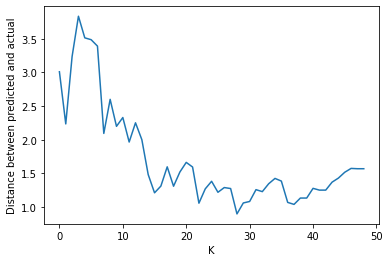

Best Value of K: 29


In [30]:
sims = itemsim(pearsSim, jes_df)

predictions = [predictRating(4, 5, i, sims) for i in range(1,50) ]
dists = [abs(predictions[i] - jes_df[4][5]) for i in range(len(predictions))]

plt.plot(dists)
plt.ylabel('Distance between predicted and actual')
plt.xlabel('K')
plt.show()

K = dists.index(min(dists)) + 1
print("Best Value of K:", K)

In [47]:
usernum = 5
jokenum = 12

pred = predictRating(usernum, jokenum, K, sims)
print("User {} predicted {} for joke {}.".format(usernum, pred, jokenum))
print("User {} actual rating {} for joke {}.".format(usernum, jes_df[usernum][jokenum], jokenum))

usernum = 3
jokenum = 4

print('\n')

pred = predictRating(usernum, jokenum, K, sims)
print("User {} predicted {} for joke {}.".format(usernum, pred, jokenum))
print("User {} actual rating {} for joke {}.".format(usernum, jes_df[usernum][jokenum], jokenum))


User 5 predicted 6.687586206896551 for joke 12.
User 5 actual rating 6.0 for joke 12.


User 3 predicted 14.441071428571432 for joke 4.
User 3 actual rating 12.8 for joke 4.


Gets input from user ratings of certain jokes and recommends similar jokes based on user ratings

In [125]:
#gets ratings from users and puts them in a numpy array
userratings = np.zeros(100)
jokelist = []

print("Please rate these jokes from 1 to 5:\n")
for i in range(5):
    arrjoke = randint(100)
    while arrjoke in jokelist:
        arrjoke = randint(100)
    jokelist.append(arrjoke)
    
    print(jokes_df[arrjoke])
    jokescore = input()*5
    print()
    userratings[arrjoke] = jokescore

Please rate these jokes from 1 to 5:

A bus station is where a bus stops.A train station is where a train stops.On my desk I have a work station...
1

The graduate with a Science degree asks "Why does it work?"The graduate with an Engineering degree asks "How does it work?"The graduate with an Accounting degree Asks "How much will it cost?" The graduate with a  Liberal Arts degree asks "Do you want fries with  that?"
2

A Jewish young man was seeing a psychiatrist for an eating and sleeping disorder. "I am so obsessed with my mother... As soon as I go to sleep I start dreaming and everyone in my dream turns into my mother. I wake up in such a state all I can do is go downstairs and eat a piece of toast."The psychiatrist replies:"What just one piece of toast for a big boy like you?"
3

Q. What's the difference between a man and a toilet? A. A toilet doesn't follow you around after you use it.
4

Q: What is the difference between George  Washington Richard Nixon and Bill Clinton? A: Wash

In [126]:
userdict = {}
#gets the similarities of the ratings of jokes from the users inputs to other users
for i in range(100):
    userdict[i] = cosine_similarity([jes_df[i]], [userratings])[0][0]

similarusers = sorted(userdict, key=userdict.get)

topsimur = np.zeros((5, 100))
#gets the top 5 user ratings from similar users
for i in range(5):
    topsimur[i] = jes_df[similarusers[i]]
#gets the average scores of the jokes among the 5 users    
avgscores = np.average(topsimur, axis = 0)


avgdict = {}
for i in range(100):
    avgdict[i] = avgscores[i]

#sorts the jokes to get the top 5 jokes    
similarscores = sorted(userdict, key=userdict.get)

In [127]:
print("Your top 5 recommended jokes are: \n")
for i in range(5):
    print(jokes_df[similarscores[i]], "\n ")

Your top 5 recommended jokes are: 

Q: What's the difference between greeting a Queen and greeting thePresident of the United  States?A: You only have to get on one knee to greet the queen. 
 
Q: How do you keep a computer programmer in the shower all day long?A: Give them a shampoo with a label that says"rinse lather repeat". 
 
How many Irishmen does it take to change a light bulb?Two one to hold the lightbulb and the other to drink until the room spins. 
 
What did the Buddhist say to the hot dog vendor?Make me one with everything. 
 
An Asian man goes into a New York CityBank to exchange 10000 yen forAmerican Currency.  The teller gives him $72.00.  The next month theAsian man goes into the same bank with 10000 yen and receives $62.00.He asks "How come? Only $62.00?" The teller says "Fluctuations-Fluctuations!"Whereupon the Asian man looks back at the teller and says "Fluk youAmelicans too!" 
 
